In [107]:
import pandas as pd
import time
from tqdm import tqdm
import sys
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import warnings
import matplotlib.pyplot as plt
import cProfile
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
warnings.filterwarnings("ignore")

class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(d2l.DATA_URL+ 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))
            
    def preprocess(self, std_flag=True):
        label = 'SalePrice'
        features = pd.concat((self.raw_train.drop(columns=['Id',label]),
                              self.raw_val.drop(columns=['Id'])))
        numeric_features = features.dtypes[features.dtypes!='object'].index
        if std_flag:
            features[numeric_features] = features[numeric_features].apply(lambda x: (x-x.mean())/x.std())
        features[numeric_features] = features[numeric_features].fillna(0)
        features = pd.get_dummies(features, dummy_na=True)
        self.train = features[:self.raw_train.shape[0]].copy()
        self.train[label] = self.raw_train[label]
        self.val = features[self.raw_train.shape[0]:].copy()
        
    def get_dataloader(self, train):
        label = 'SalePrice'
        data = self.train if train else self.val
        if label not in data:
            return
        get_tensor = lambda x: torch.tensor(x.values.astype(float), dtype=torch.float32)
        # tensors = (get_tensor(data.drop(columns=[label])),
        #            torch.log(get_tensor(data[label])).reshape(-1,1))
        tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
        return self.get_tensorloader(tensors, train)
    
def k_fold_data(data,k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j*fold_size,(j+1)*fold_size)
        rets.append(KaggleHouse(data.batch_size,data.train.drop(index=idx),data.train.iloc[idx]))
    return rets

def k_fold(trainer, data, k, ModelClass,hparams,plot_flag=True):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data,k)):
        model = ModelClass(**hparams)
        model.board.yscale='log'
        if not plot_flag or i != 0:
            model.board.display=False
        trainer.fit(model,data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    avg_val_loss = sum(val_loss)/len(val_loss)
    print(f'average validation log mse = {avg_val_loss}, params:{hparams}')
    return models, avg_val_loss

In [11]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)
data.preprocess()
print(data.train.shape)
print(data.val.shape)

(1460, 81)
(1459, 80)
(1460, 332)
(1459, 331)


average validation log mse = 0.1812428626418114


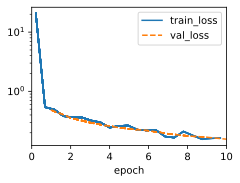

In [37]:
trainer = d2l.Trainer(max_epochs=10)
models,avg_val_loss = k_fold(trainer, data, k=5,ModelClass=d2l.LinearRegression,hparams={'lr':0.01})

In [16]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32)) for model in models]
ensemble_preds = torch.exp(torch.cat(preds,1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

# 2. Is it always a good idea to replace missing values by a mean? Hint: can you construct a situation where the values are not missing at random?



Replacing missing values with the mean is a common approach for handling missing data, but it's not always a good idea. One important consideration is whether the missing values are missing completely at random (MCAR), missing at random (MAR), or missing not at random (MNAR). Let's explore a situation where the values are not missing at random and discuss why replacing missing values with the mean might not be appropriate:

**Situation:**
Imagine you're collecting data on income and education level for a survey, but some respondents choose not to disclose their income if it's above a certain threshold. This introduces a systematic pattern of missing data based on income.

**Explanation:**
In this situation, the missing data mechanism is not random. The probability of missing data depends on the value itself (income), making it missing not at random (MNAR). People with higher incomes are more likely to withhold their income information, which introduces bias in the data.

**Implications:**
Replacing the missing values with the mean could introduce significant bias in the dataset. If you fill in missing income values with the mean income, you'll underestimate the actual income distribution and potentially mislead any analysis or modeling you perform.

**Alternative Approaches:**
In cases where data is MNAR, simply imputing missing values with the mean or other measures can lead to biased and inaccurate results. Some alternative approaches include:
- Using advanced imputation methods that consider relationships between variables.
- Creating a separate category or indicator variable to capture the fact that data is missing.
- Applying domain-specific knowledge to impute missing values.

When dealing with missing data, it's crucial to understand the underlying mechanisms causing the missingness and to choose an appropriate imputation strategy that minimizes bias and maintains the integrity of the data.

# 3. Improve the score by tuning the hyperparameters through K-fold cross-validation.



 14%|█▍        | 1/7 [00:01<00:11,  1.99s/it]

average validation log mse = 0.49889659166336064


 29%|██▊       | 2/7 [00:04<00:10,  2.15s/it]

average validation log mse = 0.3225225901603698


 43%|████▎     | 3/7 [00:06<00:08,  2.06s/it]

average validation log mse = 0.17420742630958558


 57%|█████▋    | 4/7 [00:08<00:06,  2.01s/it]

average validation log mse = 0.11064194679260253


 71%|███████▏  | 5/7 [00:10<00:03,  1.99s/it]

average validation log mse = nan


 86%|████████▌ | 6/7 [00:12<00:01,  1.97s/it]

average validation log mse = nan


100%|██████████| 7/7 [00:13<00:00,  1.99s/it]

average validation log mse = nan


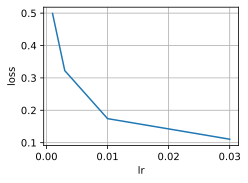

In [47]:
lr_list = [0.001,0.003,0.01,0.03,0.05,0.08,0.1]
loss_list = []
for lr in tqdm(lr_list):
    trainer = d2l.Trainer(max_epochs=10)
    models, val_loss = k_fold(trainer, data, k=5,ModelClass=d2l.LinearRegression,hparams={'lr':lr},plot_flag=False)
    loss_list.append(val_loss)
d2l.plot(lr_list,loss_list,'lr','loss')

# 4. Improve the score by improving the model (e.g., layers, weight decay, and dropout).



In [33]:
class HouseMLP(d2l.LinearRegression):
    def __init__(self, num_outputs, num_hiddens, lr, dropouts, weight_decay):
        super().__init__(lr)
        self.save_hyperparameters()
        layers = [nn.Flatten()]
        for i in range(len(num_hiddens)):
            layers.append(nn.LazyLinear(num_hiddens[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropouts[i]))
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)
        
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

average validation log mse = 0.06317381292581557


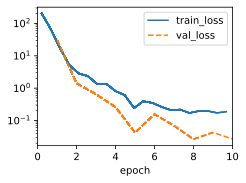

In [101]:
hparams = {'dropouts': [0.1],
 'lr': 0.03,
 'num_hiddens': [128],
 'num_outputs': 1,
 'weight_decay': 0}
trainer = d2l.Trainer(max_epochs=10)
models,avg_val_loss = k_fold(trainer, data, k=5,ModelClass=HouseMLP,hparams=hparams,plot_flag=True)

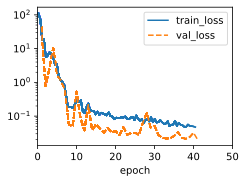

In [ ]:
hparams = {'dropouts': [0.1,0],
 'lr': 0.01,
 'num_hiddens': [128,64],
 'num_outputs': 1,
 'weight_decay': 0}
trainer = d2l.Trainer(max_epochs=50)
models,avg_val_loss = k_fold(trainer, data, k=5,ModelClass=HouseMLP,hparams=hparams,plot_flag=True)

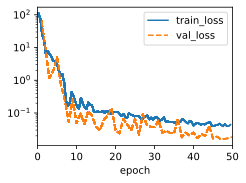

In [ ]:
from sklearn.model_selection import ParameterGrid
# hiddens = [[i] for i in d2l.gen_logrithm_nums(initial_value = 2, growth_factor = 2, num_elements = 12)]
param_grid = {
    'num_outputs' : [1],
    'num_hiddens': [[128,64],[256,128]],
    'dropouts':[[0,0],[0,0.1],[0.1,0]],
    'lr': [0.01],
    'weight_decay':[0]
}
loss_list = []
min_val_loss = sys.maxsize
best_hparams = None
for hparams in ParameterGrid(param_grid):
    trainer = d2l.Trainer(max_epochs=50)
    models,avg_val_loss = k_fold(trainer, data, k=5,ModelClass=HouseMLP,hparams=hparams,plot_flag=True)
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        best_hparams = hparams
    loss_list.append(avg_val_loss)
d2l.plot(list(range(len(loss_list))),loss_list,'num_hiddens','loss')
best_hparams

average validation log mse = 0.15597612142562864
average validation log mse = 0.13577107995748522
average validation log mse = 0.15525818824768067
average validation log mse = 0.08841185145080088
average validation log mse = 0.05512222554534674
average validation log mse = 0.051144136339426036
average validation log mse = 0.05264632806181907
average validation log mse = 0.09473576806485652
average validation log mse = 0.14789447471499445
average validation log mse = 0.07303549513220786
average validation log mse = 0.12492370799183845
average validation log mse = 0.094398273229599
average validation log mse = 0.15588923692703247
average validation log mse = 0.1559228077530861
average validation log mse = 0.13547121971845627
average validation log mse = 0.11138698883354663
average validation log mse = 0.09907439850270747
average validation log mse = 0.0773102281242609
average validation log mse = 0.042829845622181895
average validation log mse = 0.06431130655109882
average validation log

{'dropouts': [0.1],
 'lr': 0.03,
 'num_hiddens': [128],
 'num_outputs': 1,
 'weight_decay': 0}

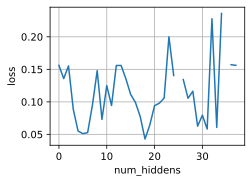

In [100]:
from sklearn.model_selection import ParameterGrid
hiddens = [[i] for i in d2l.gen_logrithm_nums(initial_value = 2, growth_factor = 2, num_elements = 12)]
param_grid = {
    'num_outputs' : [1],
    'num_hiddens': hiddens,
    'dropouts':[[0],[0.1],[0.5],[0.9]],
    'lr': [0.03],
    'weight_decay':[0]
}
loss_list = []
min_val_loss = sys.maxsize
best_hparams = None
for hparams in ParameterGrid(param_grid):
    trainer = d2l.Trainer(max_epochs=10)
    models,avg_val_loss = k_fold(trainer, data, k=5,ModelClass=HouseMLP,hparams=hparams,plot_flag=False)
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        best_hparams = hparams
    loss_list.append(avg_val_loss)
d2l.plot(list(range(len(loss_list))),loss_list,'num_hiddens','loss')
best_hparams

  8%|▊         | 1/12 [00:02<00:23,  2.12s/it]

average validation log mse = 0.1559700670838356


 17%|█▋        | 2/12 [00:04<00:21,  2.11s/it]

average validation log mse = 0.15578327625989913


 25%|██▌       | 3/12 [00:06<00:19,  2.13s/it]

average validation log mse = 0.13895011991262435


 33%|███▎      | 4/12 [00:08<00:18,  2.30s/it]

average validation log mse = 0.10713853552937506


 42%|████▏     | 5/12 [00:11<00:17,  2.49s/it]

average validation log mse = 0.08525513358414173


 50%|█████     | 6/12 [00:15<00:17,  2.90s/it]

average validation log mse = 0.07017345719039439


 58%|█████▊    | 7/12 [00:18<00:14,  2.84s/it]

average validation log mse = 0.09145292930305003


 67%|██████▋   | 8/12 [00:21<00:11,  2.99s/it]

average validation log mse = 0.08335102312266826


 75%|███████▌  | 9/12 [00:24<00:09,  3.03s/it]

average validation log mse = 0.09956287808716298


 83%|████████▎ | 10/12 [00:28<00:06,  3.42s/it]

average validation log mse = 0.07146885335445405


 92%|█████████▏| 11/12 [00:33<00:03,  3.91s/it]

average validation log mse = 0.05483937889337539


100%|██████████| 12/12 [00:41<00:00,  3.48s/it]

average validation log mse = 0.10901849515736103


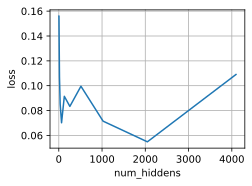

In [53]:
hiddens = d2l.gen_logrithm_nums(initial_value = 2, growth_factor = 2, num_elements = 12)
loss_list = []
for hidden in tqdm(hiddens):
    hparams = {'num_outputs':1,'num_hiddens':[hidden],
               'dropouts':[0],'lr':0.03,'weight_decay':0}
    trainer = d2l.Trainer(max_epochs=10)
    models,avg_val_loss = k_fold(trainer, data, k=5,ModelClass=HouseMLP,hparams=hparams,plot_flag=False)
    loss_list.append(avg_val_loss)
d2l.plot(hiddens,loss_list,'num_hiddens','loss')

 25%|██▌       | 1/4 [00:05<00:17,  5.80s/it]

average validation log mse = 0.09637121334671975


 50%|█████     | 2/4 [00:12<00:12,  6.16s/it]

average validation log mse = 0.08548261269927025


 75%|███████▌  | 3/4 [00:19<00:06,  6.70s/it]

average validation log mse = 0.10088834322988986


100%|██████████| 4/4 [00:25<00:00,  6.46s/it]

average validation log mse = nan


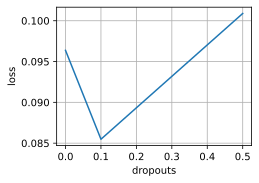

In [54]:
loss_list = []
dropouts = [0,0.1,0.5,0.9]
for dropout in tqdm(dropouts):
    hparams = {'num_outputs':1,'num_hiddens':[2048],
               'dropouts':[dropout],'lr':0.03,'weight_decay':0}
    trainer = d2l.Trainer(max_epochs=10)
    models,avg_val_loss = k_fold(trainer, data, k=5,ModelClass=HouseMLP,hparams=hparams,plot_flag=False)
    loss_list.append(avg_val_loss)
d2l.plot(dropouts,loss_list,'dropouts','loss')

average validation log mse = nan


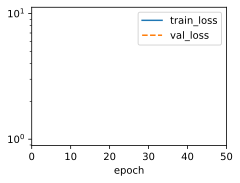

In [90]:
hparams = {'num_outputs':1,'num_hiddens':[2048,1024],
               'dropouts':[0]*2,'lr':0.001,'weight_decay':0}
trainer = d2l.Trainer(max_epochs=50)
models,avg_val_loss = k_fold(trainer, data, k=5,ModelClass=HouseMLP,hparams=hparams)

 10%|█         | 1/10 [00:05<00:45,  5.07s/it]

average validation log mse = 0.38017837405204774


 20%|██        | 2/10 [00:12<00:52,  6.54s/it]

average validation log mse = 13.644279939532279


 30%|███       | 3/10 [00:17<00:41,  5.95s/it]

average validation log mse = 0.3754747492074967


 40%|████      | 4/10 [00:23<00:33,  5.63s/it]

average validation log mse = 0.3778238511085511


 50%|█████     | 5/10 [00:28<00:27,  5.50s/it]

average validation log mse = 0.40622438788414


 60%|██████    | 6/10 [00:33<00:22,  5.52s/it]

average validation log mse = 0.38827632665634154


 70%|███████   | 7/10 [00:40<00:17,  5.83s/it]

average validation log mse = 0.36584885001182554


 80%|████████  | 8/10 [00:48<00:13,  6.60s/it]

average validation log mse = 0.3892289334535599


 90%|█████████ | 9/10 [01:03<00:09,  9.19s/it]

average validation log mse = 0.40631776690483096


100%|██████████| 10/10 [01:18<00:00,  7.87s/it]

average validation log mse = 0.39205386698246003


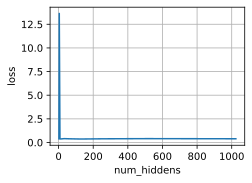

In [58]:
hiddens = d2l.gen_logrithm_nums(initial_value = 2, growth_factor = 2, num_elements = 10)
loss_list = []
for hidden in tqdm(hiddens):
    hparams = {'num_outputs':1,'num_hiddens':[2048,hidden],
               'dropouts':[0]*2,'lr':0.001,'weight_decay':0}
    trainer = d2l.Trainer(max_epochs=10)
    models,avg_val_loss = k_fold(trainer, data, k=5,ModelClass=HouseMLP,hparams=hparams,plot_flag=False)
    loss_list.append(avg_val_loss)
d2l.plot(hiddens,loss_list,'num_hiddens','loss')

In [87]:
from sklearn.model_selection import ParameterGrid

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_hidden_units': [64, 128, 256],
    # ... other hyperparameters ...
}
for params in ParameterGrid(param_grid):
    print(params)

{'learning_rate': 0.001, 'num_hidden_units': 64}
{'learning_rate': 0.001, 'num_hidden_units': 128}
{'learning_rate': 0.001, 'num_hidden_units': 256}
{'learning_rate': 0.01, 'num_hidden_units': 64}
{'learning_rate': 0.01, 'num_hidden_units': 128}
{'learning_rate': 0.01, 'num_hidden_units': 256}
{'learning_rate': 0.1, 'num_hidden_units': 64}
{'learning_rate': 0.1, 'num_hidden_units': 128}
{'learning_rate': 0.1, 'num_hidden_units': 256}


# 5. What happens if we do not standardize the continuous numerical features as we have done in this section?

If you do not standardize the continuous numerical features before training a machine learning model, it can lead to several issues that may affect the performance and convergence of the model. Standardization (also known as feature scaling) involves transforming the features to have zero mean and unit variance. Here are some consequences of not standardizing the features:

1. **Feature Magnitudes Impact:** Machine learning algorithms, especially those based on distance metrics (e.g., k-nearest neighbors, support vector machines), are sensitive to the scale of features. Features with larger magnitudes can dominate those with smaller magnitudes, leading to biased or suboptimal results.

2. **Slow Convergence:** Gradient-based optimization algorithms (e.g., gradient descent) may converge slowly or fail to converge if features have different scales. This is because the optimization process takes longer to find optimal weights for each feature.

3. **Model Interpretability:** Coefficients or weights assigned to features become less interpretable when features are not standardized. It becomes difficult to compare the importance of different features in the model.

4. **Regularization Effects:** Some regularization techniques assume that features are on a similar scale. Without standardization, regularization terms may not work as intended and penalize features with larger magnitudes more than necessary.

5. **Incorrect Feature Importance:** Feature importance measures may be skewed if features have different scales. Features with larger scales may appear more important even if they aren't.

6. **Inaccurate Distance Metrics:** Algorithms relying on distance metrics may perform poorly, as distances between instances are affected by feature scales.

7. **Inconsistent Comparisons:** Comparing two instances or data points becomes challenging when their features are on different scales.

8. **Sensitivity to Outliers:** Features with larger scales are more sensitive to outliers, potentially leading to biased models.

To address these issues, it's generally recommended to standardize continuous numerical features before feeding them into a machine learning model. Common methods for standardization include z-score normalization (subtracting the mean and dividing by the standard deviation) or Min-Max scaling (scaling features to a specific range, e.g., [0, 1]). Standardization ensures that each feature contributes equally to the model's learning process and helps the model achieve better convergence and generalization on unseen data.

average validation log mse = nan


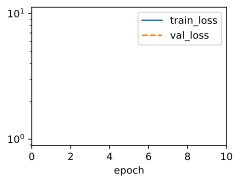

In [85]:
data = KaggleHouse(batch_size=64)
data.preprocess(std_flag=False)
trainer = d2l.Trainer(max_epochs=10)
models,avg_val_loss = k_fold(trainer, data, k=5,ModelClass=d2l.LinearRegression,hparams={'lr':0.01})